In [1]:
import os
import glob
import pytest
import numpy as np
import corgidrp.data as data
import corgidrp.mocks as mocks
import corgidrp.detector as detector
import corgidrp.l2a_to_l2b as l2a_to_l2b
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Generate mock input data and pass into flat division function
"""
###### create simulated data
# check that simulated data folder exists, and create if not
datadir = os.path.join(os.path.dirname('test'), "simflatdata")
if not os.path.exists(datadir):
    os.mkdir(datadir)
    
mocks.create_flat_calib_files(filedir=datadir)

In [3]:
####### test data architecture 
### check if there are 10 files
flat_filenames = glob.glob(os.path.join(datadir, "simcal_flat*.fits"))

flat_dataset = data.Dataset(flat_filenames)

assert len(flat_dataset) == 10

In [4]:
# display the ten images that are used for creating flat
im_max_array=[]; im_min_array=[]; im_std_array=[];
for i in range(0,10):
    im=fits.getdata(flat_filenames[i])
    im_max=np.max(im)
    im_min=np.min(im)
    im_std=np.std(im)
    im_max_array.append(im_max)
    im_min_array.append(im_min)
    im_std_array.append(im_std)
print("Max values of the images =", im_max_array)   
print("Min values of the images =", im_min_array)  
print("Std values of the images =", im_std_array)    

Max values of the images = [1.0521428105741673, 1.050312922010232, 1.0492989900622829, 1.050316396577612, 1.050250963841579, 1.0503468907652613, 1.0491359411678376, 1.0503906727399142, 1.0490298758429357, 1.0518204225439023]
Min values of the images = [0.9496408003531838, 0.9522178641427266, 0.9541035663502095, 0.9492359087008593, 0.9525005602288115, 0.950245494099894, 0.9506716478703111, 0.9527782734528316, 0.9513474231457663, 0.9481027111929206]
Std values of the images = [0.010000943722629316, 0.01000124518834392, 0.009988944326694837, 0.009997227223346521, 0.010001980313383504, 0.009999392143117326, 0.01000445288947456, 0.009992061821400519, 0.00999901140824875, 0.01000051146739932]


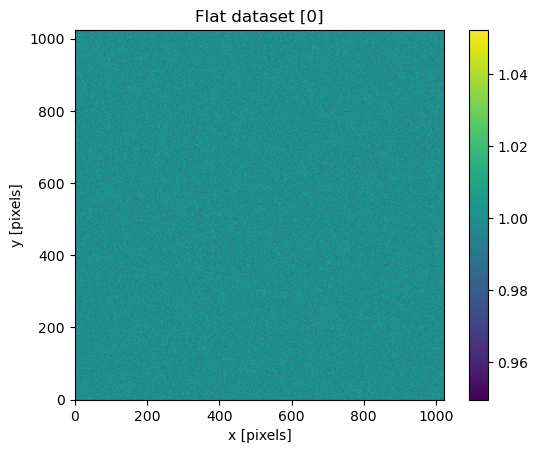

In [5]:
fig=plt.figure(dpi=100)
ax2=plt.subplot(111)
im2=ax2.imshow(flat_dataset[0].data,cmap='viridis')
ax2.invert_yaxis()
ax2.set_ylabel('y [pixels]')
ax2.set_xlabel('x [pixels]')
ax2.set_title('Flat dataset [0]')
cb=plt.colorbar(im2,orientation='vertical')

In [6]:
# check that data is consistently modified
flat_dataset.all_data[0,0,0] = 1
assert flat_dataset[0].data[0,0] == 1
    
flat_dataset[0].data[0,0] = 1
assert flat_dataset.all_data[0,0,0] == 1

###### create master flat
flat_frame = detector.create_master_flat(flat_dataset)
    
    
# check that the error is determined correctly
assert np.array_equal(np.std(flat_dataset.all_data, axis = 0)/np.sqrt(len(flat_dataset)), flat_frame.err)
    
# save flat
calibdir = os.path.join(os.path.dirname('test'), "testcalib")
flat_filename = "sim_flat_calib.fits"
if not os.path.exists(calibdir):
    os.mkdir(calibdir)
    flat_frame.save(filedir=calibdir, filename=flat_filename)    

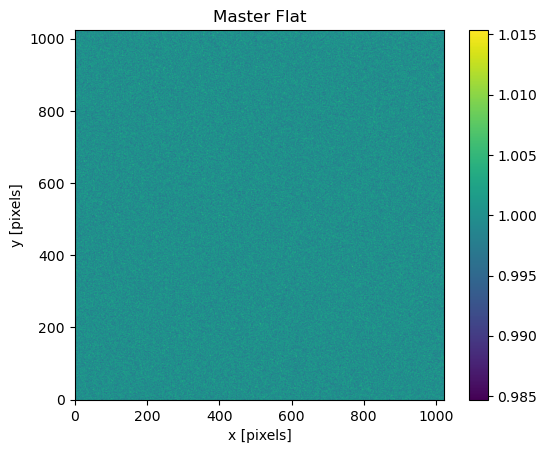

In [7]:
fig=plt.figure(dpi=100)
ax2=plt.subplot(111)
im2=ax2.imshow(flat_frame.data,cmap='viridis')
ax2.invert_yaxis()
ax2.set_ylabel('y [pixels]')
ax2.set_xlabel('x [pixels]')
ax2.set_title('Master Flat')
cb=plt.colorbar(im2,orientation='vertical')

In [8]:
###### perform flat division
# load in the masterflat
flat_filepath = os.path.join(calibdir, flat_filename)
new_masterflat = data.Masterflat(flat_filepath)
# divide sim_data from masterflat
flat_dataset = l2a_to_l2b.flat_division(flat_dataset, new_masterflat)
#assert(flat_filename in str(flat_dataset[0].ext_hdr["HISTORY"]))

# check the level of the dataset is now approximately 0 
assert np.mean(flat_dataset.all_data) == pytest.approx(1, abs=1e-2)
# check the propagated errors
assert flat_dataset[0].err_hdr["Layer_2"] == "masterflat_error"
assert(np.mean(flat_dataset.all_err) == pytest.approx(np.mean(flat_frame.err), abs = 1e-2))
print("mean of all data:", np.mean(flat_dataset.all_data))
print("mean of all errors:", np.mean(flat_dataset.all_err))
print(flat_dataset[0].ext_hdr)

mean of all data: 1.0
mean of all errors: 0.0029173101230186333
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               ARRTYPE = 'SCI     '                                                            SCTSRT  = '2024-01-01T12:00:00.000Z'                                            SCTEND  = '2024-01-01T20:00:00.000Z'                                            STATUS  =                    0                                                  HVCBIAS =                    1                          